In [25]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict , Annotated
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
import operator

In [26]:
load_dotenv() 

True

In [27]:
api_key = os.getenv("GEMINI_API_KEY")

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=api_key  
)

### 🧠 Workflow Question

**Task:**  
Make a workflow to **evaluate an essay** based on the following three parameters:

1. **Clarity of Thought** – How clearly the ideas are presented and structured.  
2. **Language** – The quality, accuracy, and fluency of the language used.  
3. **Depth of Analysis** – How well the essay explores, supports, and connects its arguments.

**Requirements:**
- Each parameter should be evaluated **independently** (preferably using **parallel nodes**).  
- Each node should return:
  - A **text feedback** (qualitative evaluation)  
  - A **numerical score** for that parameter  

**Goal:**  
After all evaluations are done:
- **Merge** the individual outputs into a final summary node.  
- The final node should:
  - Combine all text feedback into a **summarized feedback report**  
  - Calculate the **average score** across the three parameters  
  - Return the **final evaluation** containing:
    - Combined textual feedback  
    - Average numerical score


In [28]:
# Define Evaluation Schema

class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback for the essay")
    score:  int = Field(description="Score out of 10 for the essay", ge=0, le=10)


In [29]:
structured_model = model.with_structured_output(EvaluationSchema)

In [30]:
essay = """In today's rapidly evolving world, technology plays a pivotal role in shaping our lives. 
From communication to healthcare, technological advancements have revolutionized various sectors, 
enhancing efficiency, accuracy, and accessibility. The rise of artificial intelligence, automation, 
and data-driven systems has not only simplified everyday tasks but also transformed industries such 
as education, transportation, and finance.

However, while these innovations bring undeniable benefits, they also introduce new challenges that 
demand careful consideration. Issues like data privacy, job displacement, and digital addiction 
highlight the importance of responsible innovation. It is essential to strike a balance between 
embracing progress and preserving the human values that define our society. 

Education systems must adapt to equip individuals with the skills needed to thrive in a tech-driven 
economy, while policymakers should ensure that ethical standards guide the development and deployment 
of emerging technologies. As we continue to navigate this digital age, our collective responsibility 
is to use technology as a tool for empowerment, not exploitation, fostering a harmonious coexistence 
between humans and machines."""


In [31]:
prompt = f"""Evaluate the following essay based on the criteria of Clarity of Thought, Language, and Depth of Analysis.
{essay}
"""

structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay is well-structured and presents a balanced perspective on technology's impact, highlighting both its advantages and challenges. The language is clear, concise, and professional, demonstrating a strong command of vocabulary and grammar. The arguments flow logically, making it easy to understand the author's viewpoint. To enhance the depth of analysis, the essay could benefit from more specific examples or a deeper exploration of the challenges and proposed solutions. For instance, elaborating on specific types of job displacement or concrete policy measures for ethical technology development would strengthen the arguments further.", score=8)


**Explanation:**

`individual_scores: Annotated[list[int], operator.add]`

- `individual_scores` holds the list of numeric scores returned by each evaluation node.  
- The `Annotated[...]` syntax with `operator.add` defines a **reducer function** — it merges or adds together the results from multiple parallel nodes.  
- This mechanism ensures that LangGraph correctly **aggregates scores** from the three evaluation parameters: **Clarity**, **Language**, and **Depth of Analysis**.

 

In [32]:
# define state

class EssayEvaluationState(TypedDict):

    essay: str
    clarity_feedback: str
    language_feedback: str
    depth_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add] # here add is a reducer function
    average_score: float


In [33]:
def evaluate_clarity(state: EssayEvaluationState) -> EssayEvaluationState:
    prompt = f"""Evaluate the following essay for Clarity of Thought:
             {state['essay']} Provide detailed feedback and a score out of 10."""
    result = structured_model.invoke(prompt)
    clr_feedback = result.feedback
    clr_score = result.score
    return {
        'clarity_feedback': clr_feedback,
        'individual_scores': [clr_score]
    }

In [34]:
def evaluate_language(state: EssayEvaluationState) -> EssayEvaluationState:
    prompt = f"""Evaluate the following essay for Language Quality:
             {state['essay']} Provide detailed feedback and a score out of 10."""
    result = structured_model.invoke(prompt)
    lang_feedback =  result.feedback
    lang_score = result.score
    return {
        'language_feedback': lang_feedback,
        'individual_scores': [lang_score]
    }

In [35]:
def evaluate_depth(state: EssayEvaluationState) -> EssayEvaluationState:
    prompt = f"""Evaluate the following essay for Depth of Analysis:
             {state['essay']} Provide detailed feedback and a score out of 10."""
    result = structured_model.invoke(prompt)
    depth_feedback = result.feedback
    depth_score = result.score
    return {
        'depth_feedback': depth_feedback,
        'individual_scores': [depth_score]
    }

In [41]:
def final_evaluation(state: EssayEvaluationState) -> EssayEvaluationState:
    prompt = f"""Based on the following feedbacks, provide a summarized feedback for the essay:
                Clarity Feedback: {state['clarity_feedback']}
                Language Feedback: {state['language_feedback']}
                Depth Feedback: {state['depth_feedback']}
                """
    result = model.invoke(prompt)
    overall_feedback = result.content


    average_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {
        'overall_feedback': overall_feedback,
        'average_score': average_score
    }

<img src="essay.png" width = 450px, height = 300px>

In [42]:
graph = StateGraph(EssayEvaluationState)


graph.add_node('evaluate_clarity',evaluate_clarity)
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_depth',evaluate_depth)
graph.add_node('final_evaluation',final_evaluation)


graph.add_edge(START, 'evaluate_clarity')
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_depth')
graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_depth', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()


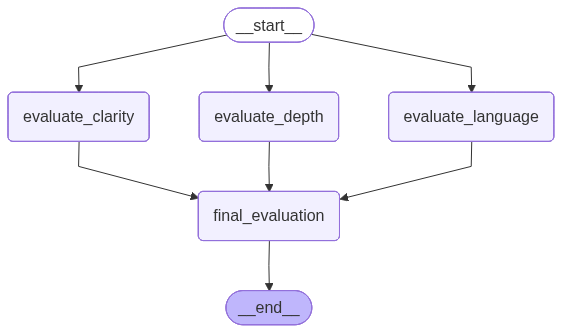

In [38]:
workflow 

In [43]:
# intial state

initial_state = {
    'essay': essay
}

In [44]:
# execute the workflow

final_state = workflow.invoke(initial_state)

In [45]:
final_state

{'essay': "In today's rapidly evolving world, technology plays a pivotal role in shaping our lives. \nFrom communication to healthcare, technological advancements have revolutionized various sectors, \nenhancing efficiency, accuracy, and accessibility. The rise of artificial intelligence, automation, \nand data-driven systems has not only simplified everyday tasks but also transformed industries such \nas education, transportation, and finance.\n\nHowever, while these innovations bring undeniable benefits, they also introduce new challenges that \ndemand careful consideration. Issues like data privacy, job displacement, and digital addiction \nhighlight the importance of responsible innovation. It is essential to strike a balance between \nembracing progress and preserving the human values that define our society. \n\nEducation systems must adapt to equip individuals with the skills needed to thrive in a tech-driven \neconomy, while policymakers should ensure that ethical standards gui